# Project 6 - Team 2
Joe, Getong, Abby

In this project, the following items were performed.

1) Select 4 datasets

2) For each dataset, cluster the images using K-Means and plot the elbow graph to show the best K.

3) Train a classifier to determine which object is represented in each image and evaluate it on the validation set.

4) Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set. Search for the number of clusters that provides the best performance.

5) Train a Gaussian mixture model  on each dataset. To speed up the algorithm, use PCA dimensionality reduction (99% variataion).

6) Graph results of your experiments for the different data sets and provide a qualitative assessment and detailed discussion of the achieved results.


# Introduction

K-means is a method of cluster analysis which aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean. It is similar to the expectation-maximization algorithm for mixtures of Gaussians in that they both attempt to find the centers of natural clusters in the data.

In addition, K-means also can work as a dimension reduction tool for machine learning. MNIST was used as the training dataset. Four of its subset (5,0,1,4) are chosen to perform K-means clustering. For each subset, all the subset has a bunch of images tagged with the same handwritten digits. 

Then, we utilize k-means clustering as a classifier and compare with another classifier Logistic Regression.

Later on, k-means clustering was performed as a dimension reduction technique in another classifier - Random Forrest.

Gaussian Mixture Model was performed on the whole dataset MNIST as well as four selected subsets (5,0,1,4).
All of these GMMs show convergence in the results.

# Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import urllib
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.mixture import GaussianMixture
import tensorflow as tf
import IPython.display as display
from PIL import Image

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Import the dataset.

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


MNIST is one of the well-known mature machine learning dataset. We know there's no missing data involved, therefore, the only thing we need to do is scaling the data from [0-255] to [0-1].

In [0]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [0]:
X_train.shape

(60000, 28, 28)

In order to perform further training, the datasets hereby are transformed into 2-dimension arrays.

In [0]:
X_train_2d = X_train.reshape(60000,-1)
X_train_2d.shape
X_test_2d = X_test.reshape(10000,-1)

In [0]:
X_train_2d.shape

(60000, 784)

# First, we take all images that tagged with 5 as a set.

In [0]:
X_train_5 = []
for i in range(len(X_train_2d)):
  if y_train[i]==5:
    X_train_5.append(X_train_2d[i])
X_train_5=np.asarray(X_train_5)
X_train_5.shape

(5421, 784)

There are 5,421 images that is "5".

Hereby we validate that the obtained dataset is correct by plotting some sample images.

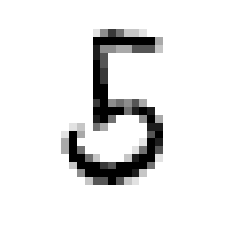

In [0]:
some_pic = X_train_5[111]
some_pic_image = some_pic.reshape(28, 28)
plt.imshow(some_pic_image, cmap=mpl.cm.binary)
plt.axis("off")

#save_fig("some_pic_plot")
plt.show()

Next, we'll train Kmeans models with k from 1 to 10 and show the inertias.
By performing k-means clustering on this sub-datasets with all images tagged with 5, we are actually looking for the best way to separate major distinctive components of these handwritten "5"s. 

In [0]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_train_5)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [0]:
inertias 

[257936.69,
 225488.1807217207,
 209975.76170453263,
 201279.8056183408,
 195169.51277534536,
 190335.951916044,
 186562.66313614574,
 183003.26347922298,
 179796.49017720844]

Saving figure inertia_vs_k_plot


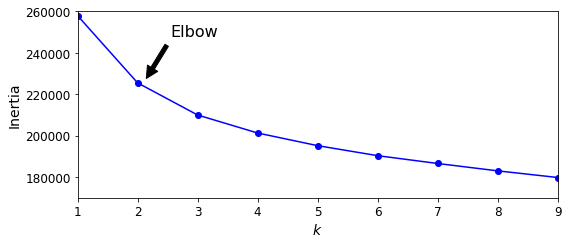

In [0]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2.1, inertias[1]),
             xytext=(0.3, 0.85),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 9, 170000, 260000])
save_fig("inertia_vs_k_plot")
plt.show()

Then let's take a look at the silhouette score, which is the mean silhouette coefficient over all the instances. 

In [0]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(X_train_5, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


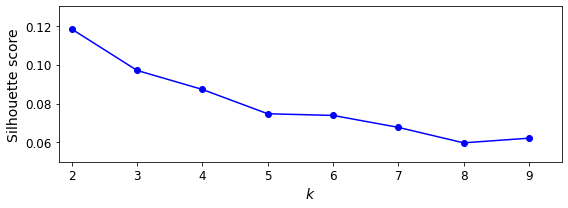

In [0]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 9.5, 0.05, 0.13])
save_fig("silhouette_score_vs_k_plot")
plt.show()

Saving figure silhouette_analysis_plot


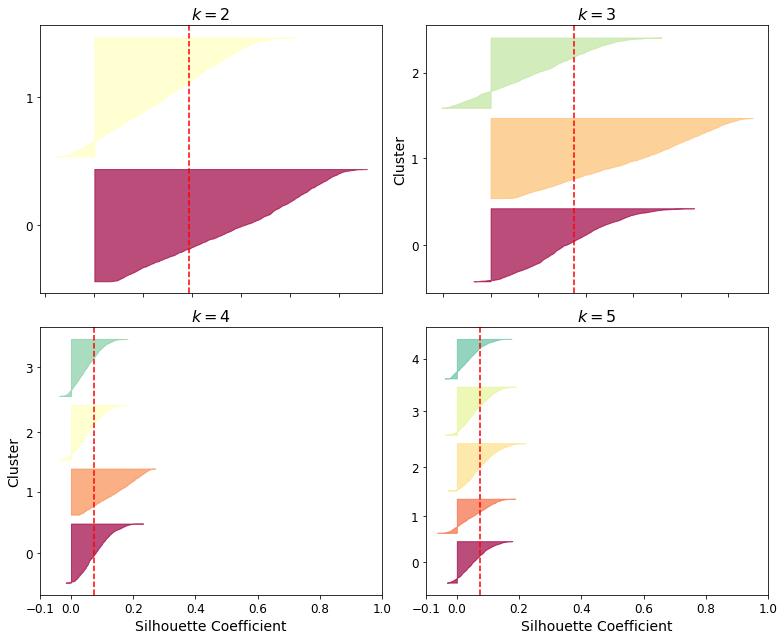

In [0]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 0].labels_
    silhouette_coefficients = silhouette_samples(X_train_5, y_pred)

    padding = len(X_train_5) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 1], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

From the Silhouette Coefficient charts we observed that actually, K = 2,3,4,5 are all good choices for clustering because all the clusters are higher than the dash line presented in each chart. 

Next, we take a look at the chart of Silhouette score that K=2 has the highest value. 

Therefore, combined inertia and silhouette scores, the best k is 2.

# Next, we take all images that tagged with 0 as a set.

In [0]:
X_train_0 = []
for i in range(len(X_train_2d)):
  if y_train[i]==0:
    X_train_0.append(X_train_2d[i])
X_train_0=np.asarray(X_train_0)
X_train_0.shape

(5923, 784)

There are 5,923 images that is "0".

Let's valid that the obtained dataset is correct by plot some sample images.

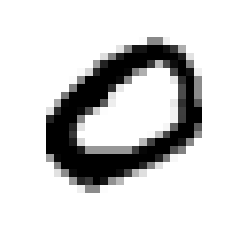

In [0]:
some_pic = X_train_0[222]
some_pic_image = some_pic.reshape(28, 28)
plt.imshow(some_pic_image, cmap=mpl.cm.binary)
plt.axis("off")

#save_fig("some_pic_plot")
plt.show()

Next, we'll train Kmeans models with k from 1 to 10 and show the inertias.

In [0]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_train_0)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
inertias

[295669.56,
 257077.23313073916,
 235491.50418072584,
 223175.91336492676,
 214289.7449950732,
 207295.15702267573,
 201838.9245987715,
 196784.88759259088,
 192584.35493524396]

Saving figure inertia_vs_k_plot


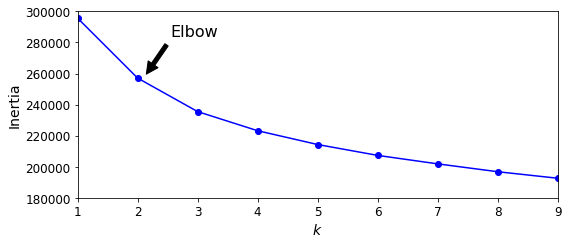

In [0]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2.1, inertias[1]),
             xytext=(0.3, 0.85),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 9, 180000, 300000])
save_fig("inertia_vs_k_plot")
plt.show()

Then let's take a look at the silhouette score, which is the mean silhouette coefficient over all the instances.

Saving figure silhouette_score_vs_k_plot


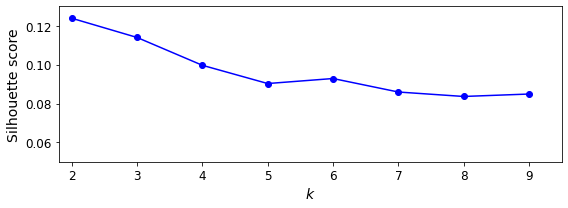

In [0]:
silhouette_scores = [silhouette_score(X_train_0, model.labels_)
                     for model in kmeans_per_k[1:]]
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 9.5, 0.05, 0.13])
save_fig("silhouette_score_vs_k_plot")
plt.show()


Saving figure silhouette_analysis_plot


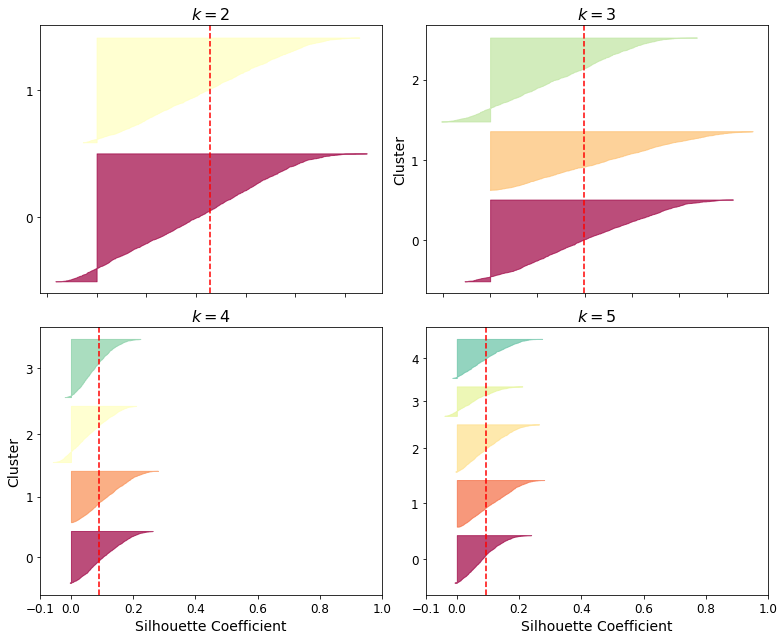

In [0]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 0].labels_
    silhouette_coefficients = silhouette_samples(X_train_0, y_pred)

    padding = len(X_train_0) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 1], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

From the Silhouette Coefficient charts we observed that actually, K = 2,3,4,5 are all good choices for clustering because all the clusters are higher than the dash line presented in each chart. 

Next, we take a look at the chart of Silhouette score that K=2 has the highest value. 

Therefore, combined inertia and silhouette scores, the best k is 2.

# Then, let's repeat the previous steps on image set of "1".

In [0]:
X_train_1 = []
for i in range(len(X_train_2d)):
  if y_train[i]==1:
    X_train_1.append(X_train_2d[i])
X_train_1=np.asarray(X_train_1)
X_train_1.shape

(6742, 784)

There are 6,742 images that is "1".

Hereby we valid the obtained dataset is correct by plot some sample images.

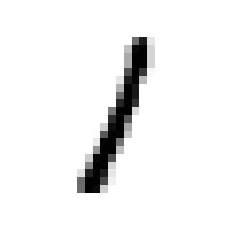

In [0]:
some_pic = X_train_1[333]
some_pic_image = some_pic.reshape(28, 28)
plt.imshow(some_pic_image, cmap=mpl.cm.binary)
plt.axis("off")

#save_fig("some_pic_plot")
plt.show()

Next, we'll train Kmeans models with k from 1 to 10 and show the inertias.

In [0]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_train_1)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

inertias

[151530.62,
 107987.4998291857,
 91598.63445507255,
 82791.3526300055,
 78205.82149241774,
 74857.43954407316,
 71635.05321992845,
 69234.45198628683,
 67351.15109910416]

Saving figure inertia_vs_k_plot


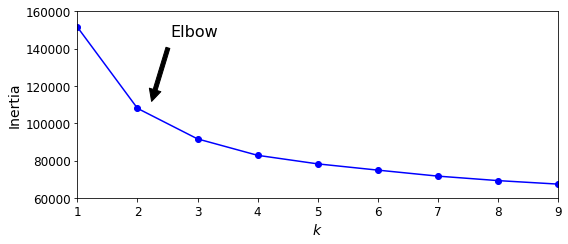

In [0]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2.2, inertias[1]),
             xytext=(0.3, 0.85),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 9, 60000, 160000])
save_fig("inertia_vs_k_plot")
plt.show()

Then let's take a look at the silhouette score, which is the mean silhouette coefficient over all the instances.

Saving figure silhouette_score_vs_k_plot


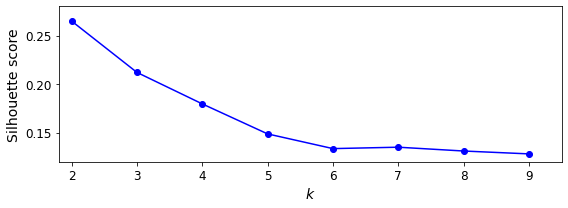

In [0]:
silhouette_scores = [silhouette_score(X_train_1, model.labels_)
                     for model in kmeans_per_k[1:]]
                     
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 9.5, 0.12, 0.28])
save_fig("silhouette_score_vs_k_plot")
plt.show()

Saving figure silhouette_analysis_plot


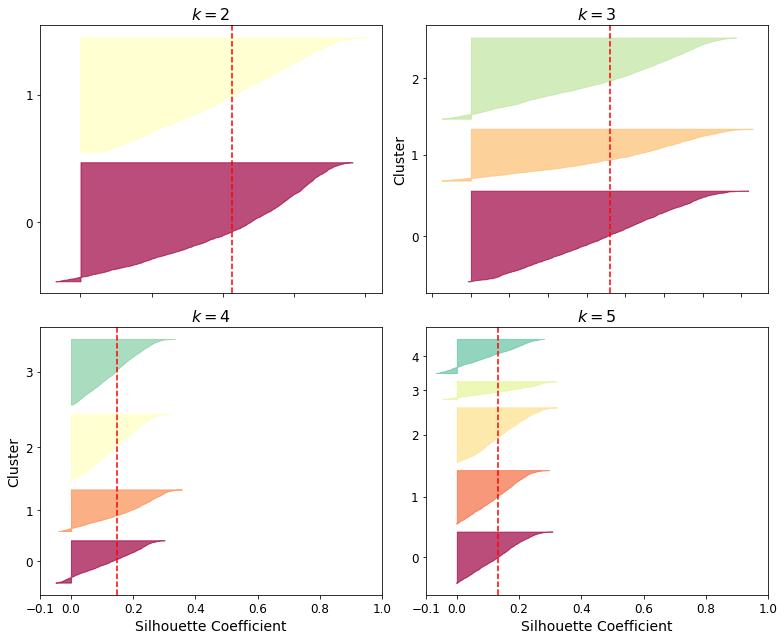

In [0]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 0].labels_
    silhouette_coefficients = silhouette_samples(X_train_1, y_pred)

    padding = len(X_train_1) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 1], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

From the Silhouette Coefficient charts we observed that actually, K = 2,3,4,5 are all good choices for clustering because all the clusters are higher than the dash line presented in each chart. 

Next, we take a look at the chart of Silhouette score that K=2 has the highest value. 

Therefore, combined inertia and silhouette scores, the best k is 2.

# Then, let's repeat the previous steps on image set of "4".

In [0]:
X_train_4 = []
for i in range(len(X_train_2d)):
  if y_train[i]==4:
    X_train_4.append(X_train_2d[i])
X_train_4=np.asarray(X_train_4)
X_train_4.shape

(5842, 784)

There are 5,842 images that is "1".

Hereby we valid the obtained dataset is correct by plot some sample images.

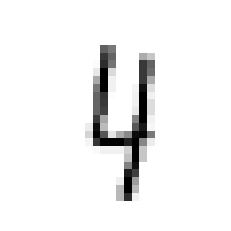

In [0]:
some_pic = X_train_4[444]
some_pic_image = some_pic.reshape(28, 28)
plt.imshow(some_pic_image, cmap=mpl.cm.binary)
plt.axis("off")

#save_fig("some_pic_plot")
plt.show()

Next, we'll train Kmeans models with k from 1 to 10 and show the inertias.

In [0]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_train_4)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
inertias

[238776.12,
 217399.23339977593,
 204581.40602276454,
 196078.6788117555,
 189592.81951648934,
 184495.00360708046,
 180442.68661409718,
 176990.3547738334,
 173890.18326893199]

Saving figure inertia_vs_k_plot


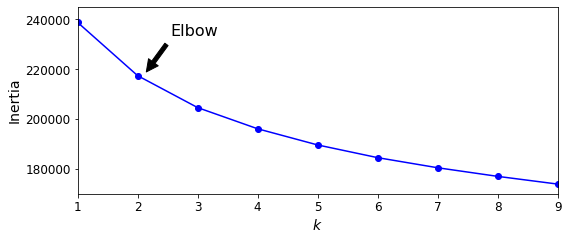

In [0]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2.1, inertias[1]),
             xytext=(0.3, 0.85),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 9, 170000, 245000])
save_fig("inertia_vs_k_plot")
plt.show()

Then let's take a look at the silhouette score, which is the mean silhouette coefficient over all the instances.

Saving figure silhouette_score_vs_k_plot


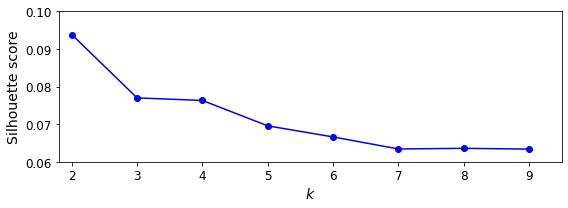

In [0]:
silhouette_scores = [silhouette_score(X_train_4, model.labels_)
                     for model in kmeans_per_k[1:]]
                     
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 9.5, 0.06, 0.10])
save_fig("silhouette_score_vs_k_plot")
plt.show()

Saving figure silhouette_analysis_plot


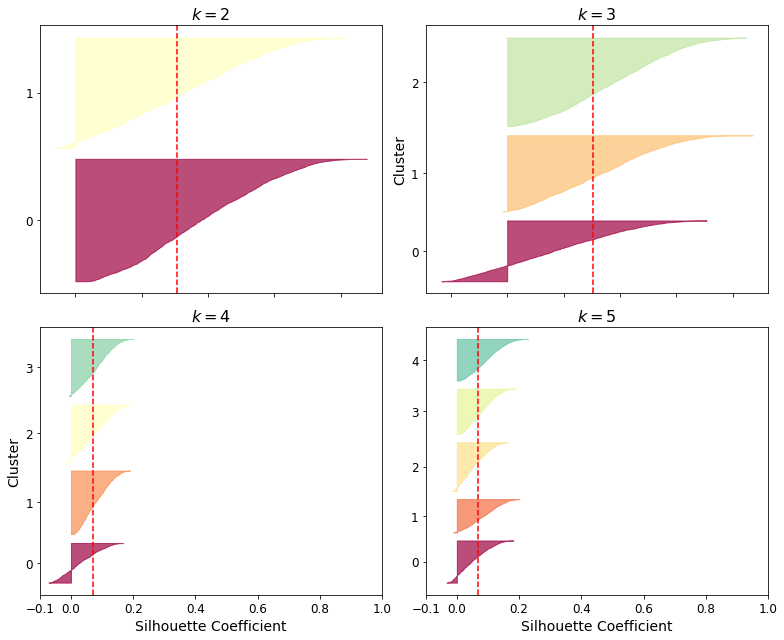

In [0]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 0].labels_
    silhouette_coefficients = silhouette_samples(X_train_4, y_pred)

    padding = len(X_train_4) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 1], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

From the Silhouette Coefficient charts we observed that actually, K = 2,3,4,5 are all good choices for clustering because all the clusters are higher than the dash line presented in each chart. 

Next, we take a look at the chart of Silhouette score that K=2 has the highest value. 

Therefore, combined inertia and silhouette scores, the best k is 2.

# Train a classifier (LogisticRegression)

Next, we'll train a classification model on the whole dataset instead of sub-sets and test its prediction rate. We use logistic regression as an example here.

In [0]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=10000, random_state=42)
log_reg.fit(X_train_2d, y_train)
log_reg.score(X_test_2d, y_test)

0.9198

The prediction accuracy is 91.98%. Let's see how is the performance after implementing the K-means algorithm.

In [0]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=10000, random_state=42)),
])
pipeline.fit(X_train_2d, y_train)
pipeline.score(X_test_2d, y_test)

0.9125

With cluster = 50, the accuracy doesn't show improvement, but get slice lower. Since this cluter number is arbitary. 

Here we try to find the best k, when the accuracy score peaks.

In practice, we found out that it will take over 2 days to finish the execution of k-mean for k through 2 to 100. 

Therefore we chose k with in interval of 10 between 10 to 100 with 3 times of cross validation. Still, it takes more than 3 hours but acceptable in our limitation.

---



In [0]:
from sklearn.model_selection import GridSearchCV
param_grid = dict(kmeans__n_clusters=range(10, 100, 10))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train_2d, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] kmeans__n_clusters=10 ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ kmeans__n_clusters=10, total= 1.3min
[CV] kmeans__n_clusters=10 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] ............................ kmeans__n_clusters=10, total= 1.5min
[CV] kmeans__n_clusters=10 ...........................................
[CV] ............................ kmeans__n_clusters=10, total= 1.6min
[CV] kmeans__n_clusters=20 ...........................................
[CV] ............................ kmeans__n_clusters=20, total= 2.5min
[CV] kmeans__n_clusters=20 ...........................................
[CV] ............................ kmeans__n_clusters=20, total= 2.5min
[CV] kmeans__n_clusters=20 ...........................................
[CV] ............................ kmeans__n_clusters=20, total= 2.5min
[CV] kmeans__n_clusters=30 ...........................................
[CV] ............................ kmeans__n_clusters=30, total= 4.3min
[CV] kmeans__n_clusters=30 ...........................................
[CV] ............................ kmeans__n_clusters=30, total= 3.9min
[CV] kmeans__n_clusters=30 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 183.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=50, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=42, tol=0.0001,
                                               verbose=0)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                      

After 27 runs, let's check the best k for this model.

In [0]:
grid_clf.best_params_

{'kmeans__n_clusters': 90}

In [0]:
grid_clf.score(X_test_2d, y_test)

0.9337

K,  from 10-90, the best value is 90, the accuracy increased from 91.98% to 93.37%

# Using K-mean Clustering as Dismension Reduction for Classification

First, let's train a random forrest classifier.

In [0]:
from sklearn.ensemble import RandomForestClassifier
import time
t0 = time.time()
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_2d, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 66.41s


In [0]:
clf.score(X_test_2d, y_test)

0.9706

Next, we'll test using K-mean (k=50) as a dimension reduction tool.

In [0]:
t2 = time.time()
test_model = KMeans(n_clusters=50, random_state=42).fit(X_train_2d)
X_train_reduced = test_model.transform(X_train_2d)
X_test_reduced = test_model.transform(X_test_2d)
t3 = time.time()
print("Training took {:.2f}s".format(t3 - t2))

Training took 379.46s


In [0]:
t4 = time.time()
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
t5 = time.time()
print("Training took {:.2f}s".format(t5 - t4))    

Training took 117.60s


In [0]:
clf.score(X_test_reduced, y_test)

0.9338

By lowing the accuracy rate 3.68%, it did work on the task of dimension reduction.

Then, let's try this again with the best K=90 and check the result.

In [0]:
t6 = time.time()
best_model = KMeans(n_clusters=90, random_state=42).fit(X_train_2d)
X_train_reduced = best_model.transform(X_train_2d)
X_test_reduced = best_model.transform(X_test_2d)
t7 = time.time()
print("Training took {:.2f}s".format(t7 - t6))  

Training took 570.63s


In [0]:
t8 = time.time()
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
t9 = time.time()
print("Training took {:.2f}s".format(t9 - t8))  

Training took 155.23s


In [0]:
clf.score(X_test_reduced, y_test)

0.9405

Well, when K get bigger like 90, it takes more time for transformation and boost the accuracy a little better from 93.38% to 94.05%, but still lower thatn the original dataset.

# Gaussian Mixture Model Test

First, let's perform PCA dimension reduction with 99% variance remained.

In [0]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train_2d)
X_test_pca = pca.transform(X_test_2d)

pca.n_components_

331

The number of dimensions of the dataset is reduced from 784 to 331.

# Train Gaussian Mixture Model. 

A Gaussian Mixture model (GMM) is a probabilistic model that assumes that the instances were generated from a mixture of several Gaussian distributions whose parameters are unknown. 

In our training process, we tried n_components = 40, it took over one and a half hour to run. Therefore, using the best k=90 would not be good idea with the time limitation. Consider there are actually 10 distinctive digits in this dataset, choosing n_components = 10 would be an appropriate solution, although might not be the best choice for best performance.

In [0]:
gm = GaussianMixture(n_components=10, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

Then, let's take a look at the parameters that the algorithm estimated.

In [0]:
gm.means_

array([[ 2.00426471e-01, -1.95378751e-01,  1.06000020e+00, ...,
         6.60053712e-04, -4.03166488e-03, -3.48220891e-03],
       [-3.48049513e+00, -1.43409793e+00,  2.39825532e-02, ...,
         4.85958695e-04,  1.43397800e-03,  1.98480693e-03],
       [ 5.22736243e-02, -7.98719182e-01,  2.95807814e-01, ...,
        -2.52149482e-04, -5.61855385e-04, -2.50798804e-03],
       ...,
       [-7.81832184e-01,  2.20868555e+00,  1.10949096e+00, ...,
        -1.40486374e-03, -3.80145375e-03, -1.16069624e-03],
       [ 1.20975787e+00, -1.20714986e+00,  2.47832126e-01, ...,
        -1.16327520e-03, -1.31094651e-03,  1.48057558e-03],
       [-1.17942125e+00,  2.18493842e+00, -1.14374491e+00, ...,
         1.29316397e-03,  1.84630745e-03,  2.36452307e-03]])

In [0]:
gm.weights_

array([0.08474994, 0.07316667, 0.15491899, 0.1040815 , 0.06398309,
       0.06287048, 0.06021713, 0.07799913, 0.17734665, 0.14066642])

In [0]:
gm.covariances_

array([[[ 2.61975542e+00,  6.63721112e-01, -1.10740614e-02, ...,
         -9.74574423e-04,  5.74516684e-04,  4.55964133e-04],
        [ 6.63721112e-01,  1.23807171e+00,  8.58680691e-03, ...,
         -2.46128073e-03, -6.83100285e-03, -5.79056013e-03],
        [-1.10740614e-02,  8.58680691e-03,  1.55569079e+00, ...,
         -1.19395520e-03, -7.43128751e-04, -3.45885556e-03],
        ...,
        [-9.74574423e-04, -2.46128073e-03, -1.19395520e-03, ...,
          5.23782946e-03,  2.86407864e-04,  3.50811328e-04],
        [ 5.74516684e-04, -6.83100285e-03, -7.43128751e-04, ...,
          2.86407864e-04,  7.60772423e-03,  2.35818185e-03],
        [ 4.55964133e-04, -5.79056013e-03, -3.45885556e-03, ...,
          3.50811328e-04,  2.35818185e-03,  7.85383389e-03]],

       [[ 1.51172456e-01,  1.45423906e-01, -1.37736177e-01, ...,
          3.11445579e-05,  4.85247592e-06, -2.52754290e-04],
        [ 1.45423906e-01,  5.71190889e-01, -3.63395724e-01, ...,
          3.48927337e-04, -1.06192312e

In [0]:
gm.converged_

True

Good, it shows that the algorithm did actually converged.

In [0]:
gm.n_iter_

83

In [0]:
gm.predict(X_train_pca)

array([3, 6, 4, ..., 2, 0, 5])

In [0]:
gm.predict_proba(X_train_pca)

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 5.42749054e-096, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       ...,
       [0.00000000e+000, 0.00000000e+000, 1.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 2.79796227e-118, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 3.11329912e-104, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000]])

Use the model to generate some new digits (inverse_transform() method is used because, PCA is performed)), and visualize them.

In [0]:
n_gen_d = 20
gen_d_reduced, y_gen_d = gm.sample(n_samples=n_gen_d)
gen_d = pca.inverse_transform(gen_d_reduced)

In [0]:
def plot_digits(digits, labels, n_cols=5):
    n_rows = (len(digits) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (digit, label) in enumerate(zip(digits, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(digit.reshape(28, 28), cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()


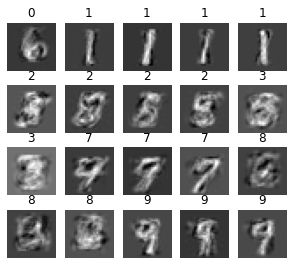

In [0]:
plot_digits(gen_d, y_gen_d)

Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the score_samples() method for normal images and for anomalies).

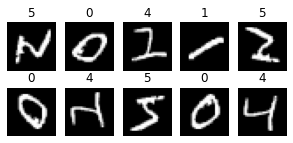

In [0]:
n_rotated = 4
rotated = np.transpose(X_train_2d[:n_rotated].reshape(-1, 28, 28), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 28*28)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train_2d[:n_flipped].reshape(-1, 28, 28)[:, ::-1]
flipped = flipped.reshape(-1, 28*28)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train_2d[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
darkened = darkened.reshape(-1, 28*28)
y_darkened = y_train[:n_darkened]

X_bad_digits = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_digits(X_bad_digits, y_bad)

In [0]:
X_bad_digits_pca = pca.transform(X_bad_digits)
gm.score_samples(X_bad_digits_pca)

array([ -34.22747065,  300.4505291 ,  184.66535546,  355.01409328,
        158.40844517,   85.72229827, -237.1952952 ,  376.76411524,
        492.18289667,  369.00925026])

Some of the bad digits are considered unlikely by the Gaussian Mixture model. The reason of not most of the digits are considered unlikely is because, unlike some objects or human faces, the handwritten digits do not show high sensitivity regarding the position. For example, if you flip a "6", it becomes a "9". Both "0" and "8" can be considered symmetric to some extend.

Then, let's compare this to the scores of some training instances:

In [0]:
gm.score_samples(X_train_pca[:10])

array([ 155.05712116,  393.70227122,  265.54496047,  706.33499228,
        537.72002155,  215.2938186 , 1029.3332956 ,  360.05500065,
       1085.27990019,  422.15779773])

# Next, let's try train GMMs for the subsets "5".

In [0]:
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train_5)
X_test_5 = []
for i in range(len(X_test_2d)):
  if y_test[i]==5:
    X_test_5.append(X_test_2d[i])
X_test_5=np.asarray(X_test_5)
X_test_pca = pca.transform(X_test_5)

pca.n_components_

282

In [0]:
gm = GaussianMixture(n_components=2, random_state=42)
y_pred = gm.fit_predict(X_train_5)

In [0]:
gm.means_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
gm.weights_

array([0.35270245, 0.64729755])

In [0]:
gm.covariances_

array([[[1.e-06, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 1.e-06, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-06, ..., 0.e+00, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 0.e+00, ..., 1.e-06, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 1.e-06, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 1.e-06]],

       [[1.e-06, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 1.e-06, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-06, ..., 0.e+00, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 0.e+00, ..., 1.e-06, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 1.e-06, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 1.e-06]]])

In [0]:
gm.converged_

True

In [0]:
gm.n_iter_

20

In [0]:
gm.predict(X_train_5)

array([0, 1, 1, ..., 1, 1, 1])

In [0]:
gm.predict_proba(X_train_5)

array([[1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000],
       [6.92363129e-282, 1.00000000e+000],
       ...,
       [2.22422015e-228, 1.00000000e+000],
       [1.92837171e-208, 1.00000000e+000],
       [1.20564181e-214, 1.00000000e+000]])

In [0]:
gm.score_samples(X_train_5)

array([1939.13099995, 2582.11057069, 2596.4272039 , ..., 2598.61366256,
       2585.08155665, 2566.78852592])

# GMMs for the subsets "0".

In [0]:
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train_0)
X_test_0 = []
for i in range(len(X_test_2d)):
  if y_test[i]==0:
    X_test_0.append(X_test_2d[i])
X_test_0=np.asarray(X_test_0)
X_test_pca = pca.transform(X_test_0)
pca.n_components_

270

In [0]:
gm = GaussianMixture(n_components=2, random_state=42)
y_pred = gm.fit_predict(X_train_0)

In [0]:
gm.means_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
gm.weights_

array([0.59210159, 0.40789841])

In [0]:
gm.covariances_

array([[[1.e-06, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 1.e-06, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-06, ..., 0.e+00, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 0.e+00, ..., 1.e-06, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 1.e-06, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 1.e-06]],

       [[1.e-06, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 1.e-06, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-06, ..., 0.e+00, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 0.e+00, ..., 1.e-06, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 1.e-06, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 1.e-06]]])

In [0]:
gm.converged_

True

In [0]:
gm.n_iter_

18

In [0]:
gm.predict(X_train_0)

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
gm.predict_proba(X_train_0)

array([[1.00000000e+000, 1.70640677e-123],
       [1.00000000e+000, 4.78282502e-146],
       [1.00000000e+000, 2.88078324e-243],
       ...,
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000]])

In [0]:
gm.score_samples(X_train_0)

array([2629.48614113, 2565.16239578, 2519.77561586, ..., 2442.94447589,
       2586.89317784, 2505.62214632])

# GMMs for the subsets "1".

In [0]:
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train_1)
X_test_1 = []
for i in range(len(X_test_2d)):
  if y_test[i]==1:
    X_test_1.append(X_test_2d[i])
X_test_1=np.asarray(X_test_1)
X_test_pca = pca.transform(X_test_1)
pca.n_components_

176

In [0]:
gm = GaussianMixture(n_components=2, random_state=42)
y_pred = gm.fit_predict(X_train_1)

In [0]:
gm.means_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
gm.weights_

array([0.64685982, 0.35314018])

In [0]:
gm.covariances_

array([[[1.e-06, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 1.e-06, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-06, ..., 0.e+00, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 0.e+00, ..., 1.e-06, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 1.e-06, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 1.e-06]],

       [[1.e-06, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 1.e-06, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-06, ..., 0.e+00, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 0.e+00, ..., 1.e-06, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 1.e-06, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 1.e-06]]])

In [0]:
gm.converged_

True

In [0]:
gm.n_iter_

29

In [0]:
gm.predict(X_train_1)

array([1, 0, 0, ..., 1, 1, 1])

In [0]:
gm.predict_proba(X_train_1)

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [0]:
gm.score_samples(X_train_1)

array([3141.64843097, 3229.32205746, 3276.07293819, ..., 3136.75001348,
       3131.9332395 , 3066.71611899])

# GMMs for the subsets "4".

In [0]:
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train_4)
X_test_4 = []
for i in range(len(X_test_2d)):
  if y_test[i]==4:
    X_test_4.append(X_test_2d[i])
X_test_4=np.asarray(X_test_4)
X_test_pca = pca.transform(X_test_4)
pca.n_components_

287

In [0]:
gm = GaussianMixture(n_components=2, random_state=42)
y_pred = gm.fit_predict(X_train_4)

In [0]:
gm.means_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
gm.weights_

array([0.69513812, 0.30486188])

In [0]:
gm.covariances_

array([[[1.e-06, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 1.e-06, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-06, ..., 0.e+00, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 0.e+00, ..., 1.e-06, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 1.e-06, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 1.e-06]],

       [[1.e-06, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 1.e-06, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-06, ..., 0.e+00, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 0.e+00, ..., 1.e-06, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 1.e-06, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 1.e-06]]])

In [0]:
gm.converged_

True

In [0]:
gm.n_iter_

33

In [0]:
gm.predict(X_train_4)

array([1, 0, 1, ..., 1, 1, 0])

In [0]:
gm.predict_proba(X_train_4)

array([[0.00000000e+000, 1.00000000e+000],
       [1.00000000e+000, 2.19645925e-157],
       [0.00000000e+000, 1.00000000e+000],
       ...,
       [0.00000000e+000, 1.00000000e+000],
       [0.00000000e+000, 1.00000000e+000],
       [1.00000000e+000, 1.42990870e-262]])

In [0]:
gm.score_samples(X_train_4)

array([2069.03641092, 2431.88492083, 1890.84826116, ..., 2171.53537791,
       2172.36992319, 2534.57148733])

#Graph results of our experiments and qualitative assessment.

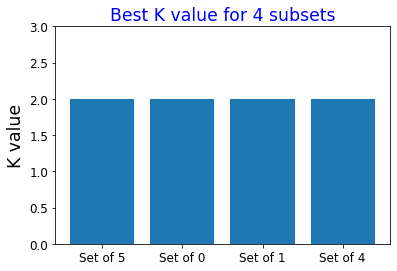

In [0]:
names = ['Set of 5', 'Set of 0', 'Set of 1','Set of 4']
values = [2, 2, 2, 2]
plt.bar(names, values)
plt.rc('xtick', labelsize=6)
plt.ylim(0,3)
plt.ylabel("K value", fontsize = "xx-large")
plt.title("Best K value for 4 subsets", color = "blue", fontsize = "xx-large")
plt.show()

From the Silhouette Coefficient charts we observed K = 2,3,4,5 are all good choices for clustering. Next, we check the chart of Silhouette score which shows that K=2 has the highest value for each subsets.

In conclusion, all of the 4 subsets having the best K value equal to 2.

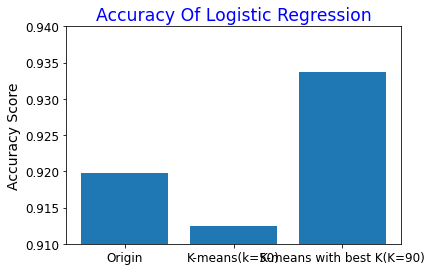

In [0]:
names = ['Origin', 'K-means(k=50)', 'K-means with best K(K=90)']
values = [0.9198, 0.9125, 0.9337]
plt.bar(names, values)
plt.rc('xtick', labelsize=6)
plt.ylim(0.91,0.94)
plt.ylabel("Accuracy Score")
plt.title("Accuracy Of Logistic Regression", color = "blue", fontsize = "xx-large")
plt.show()

In this project, we first trained MNIST dataset with Logistic Regression model on the whole dataset instead of sub-sets and test its prediction rate. The prediction accuracy for orginial data is 91.98%. 

And then we implement the K-means algorithm as dimensional reduction tool. With cluster = 50, the accuracy doesn't show improvement, but get slice lower to 91.25%. 

Since the cluter number is arbitary, we then chose k with in interval of 10 between 10 to 100 with 3 times of cross validation, and found the best K in 10-90. It took us more than 3 hours to get this best K. The accuracy increased from 91.98% to 93.37% with this best K. 

In [0]:
Error_rate_improved = 1 - (1-0.9337)/(1-0.9198) 
Error_rate_improved

0.17331670822942657

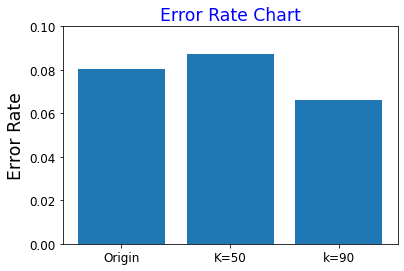

In [0]:
names = ['Origin', 'K=50', 'k=90']
values = [1-0.9198, 1-0.9125, 1-0.9337]
plt.bar(names, values)
plt.rc('xtick', labelsize=6)
plt.ylim(0,0.1)
plt.ylabel("Error Rate", fontsize = "xx-large")
plt.title("Error Rate Chart", color = "blue", fontsize = "xx-large")
plt.show()

By using K-means clustering, the error rate dropped 17.33%.

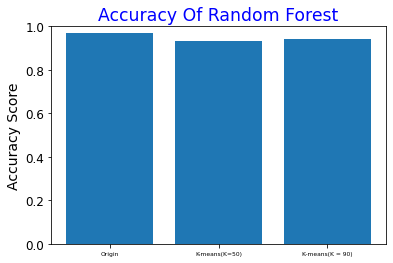

In [0]:
names = ['Origin', 'K-means(K=50)', 'K-means(K = 90)']
values = [0.9706, 0.9338, 0.9405]
plt.bar(names, values)
plt.rc('xtick', labelsize = 6)
plt.ylim(0,1) 
plt.ylabel("Accuracy Score")
plt.title("Accuracy Of Random Forest", color = "blue", fontsize = "xx-large")
plt.show()

We've also trained the whole MNIST dataset with Random Forest model. The prediction accuracy for orginial data is 97.06%, which is pretty high to start with.

Then again, we implement the K-means algorithm as dimensional reduction tool. With cluster = 50, the accuracy doesn't show improvement, but get lower to 93.38%.

And last we reduced dimension again with the K-means algorithm with cluster = 90, the best K. The accuracy increased to 94.05% from when K = 50. However, accuracy is still lower the original data. 

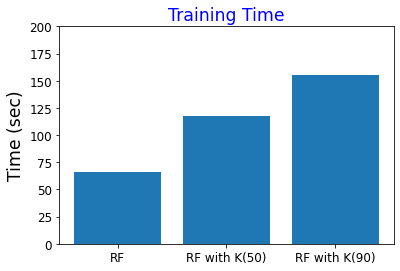

In [0]:
names = ['RF', 'RF with K(50)', 'RF with K(90)']
values = [66.41, 117.60, 155.23]
plt.bar(names, values)
plt.rc('xtick', labelsize=6)
plt.ylim(0,200)
plt.ylabel("Time (sec)", fontsize = "xx-large")
plt.title("Training Time", color = "blue", fontsize = "xx-large")
plt.show()

From the experiment, we observer that using K-means clustering as a dimension reduction tool, the training time even increased after the transformation.
Therefore, also K-means is a feasible dimension reduction technique, it is not a suit for this dataset since it prolonged the training time and lower the accuracy rate.

Another aspect that need to be taken into consideration is that the process of training a k-means transformation takes time as well. In this practice, take k=90, the training time for k-means transformation took 570.63s (9.5 minuts).